# How to AprilTag
### (getting position from information read off of AprilTags)

Ok, so turns out computer vision is hard, no surprises here. That, however is a problem
for us, because we would like our robot to see and know where it is. Luckily, we have
AprilTags, which, out of the box, are very well suited for predicting robot location. In
this document, we will figure out how to predict where a camera is relative to an AprilTag,
as measured by the FTCRobotController's builtin AprilTag pose-solver code.

(psst! skip to the Predictions section if you only care about the end result!)

----------------------------------

## Importing libraries and data

First task for us is importing libraries and data recorded from the robot.
We will be using numpy, scipy, and pyplot for analysis.

In addition, the imported data takes the following form:

- `pose_pos` is `detection.rawPose` (`.x`, `.y`, and `.z`)
- `pose_rot` is `Quaternion.fromMatrix(detection.rawPose.R, 0)`
- `gt_pos` is the expected position of the camera relative to the tag (looking at the tag, +x is forward, +y is left, +z is up)
- `gt_hdg` is the rotation of the camera about the aformentioned z-axis (counterclockwise as viewed from above, starting facing +x direction)
- `gt_rot` is the rotation of the camera specified by `gt_hdg` as a rotation object

In [2]:
from scipy.spatial.transform import Rotation as R
import numpy as np
import numpy.typing as npt
import math

import matplotlib.pyplot as plt

robot_data = np.genfromtxt('robot-vis-measurements.csv', delimiter=',')[1:,:]
pose_pos = robot_data[:, 0:3]
pose_rot = [R.from_quat([*q[1:4],q[0]]) for q in robot_data[:, 3:7]] # remember! scipy reads quaternions scalar last
gt_pos = robot_data[:, 7:10]
gt_hdg = robot_data[:, 10]
gt_rot = [R.from_rotvec([0,0,theta]) for theta in gt_hdg]
gtfwd_pos = np.array([q.inv().apply(-p) for p, q in zip(gt_pos, gt_rot)])
gtfwd_rot = [q.inv() for q in gt_rot]
[pose_pos, [q.as_quat() for q in pose_rot], gt_pos, gt_hdg, [q.as_quat() for q in gt_rot],gtfwd_pos,[q.as_quat() for q in gtfwd_rot]]

[array([[ 0.24893522,  0.79572266, 13.96521759],
        [ 0.71444452,  0.14634402, 14.11964417],
        [-9.63104343,  3.50479341, 30.20060921]]),
 [array([-0.06611157,  0.01048216,  0.01374039,  0.99766256]),
  array([-0.07440801,  0.31050897, -0.05780302,  0.94588923]),
  array([-0.04428935, -0.34753337,  0.00765533,  0.93658977])],
 array([[-12.,   0.,   0.],
        [-12., -12.,   0.],
        [-24.,  12.,   0.]]),
 array([ 0. ,  0.7, -0.7]),
 [array([0., 0., 0., 1.]),
  array([0.        , 0.        , 0.34289781, 0.93937271]),
  array([ 0.        ,  0.        , -0.34289781,  0.93937271])],
 array([[12.        ,  0.        ,  0.        ],
        [16.90871849,  1.447494  ,  0.        ],
        [26.08682474,  6.28311825,  0.        ]]),
 [array([ 0.,  0.,  0., -1.]),
  array([ 0.        ,  0.        ,  0.34289781, -0.93937271]),
  array([ 0.        ,  0.        , -0.34289781, -0.93937271])]]

## Rotation

First, you must understand quaternions. Quaternions is a little bit of mathemagics
that is really good at representing 3d rotations, hence why it's used here. We want
to learn to extract part of this data.

Info on quaternions (skip this paragraph if you don't care). Quaternions have 4
parameters $x$, $y$, $z$, and $w$, represented as $w+xi+yj+zk$ (multiplication
detailed in the table below). Quaternions used in rotation have 3 degrees of
freedom, one absorbed by requiring normalization (eg. $x^2+y^2+z^2+w^2=1$). This
matches up neatly with the 3 degrees of freedom in 3d rotation, and it turns out
it's a very convenient way to represent them. In the FTCRobotController code you
will not need to know how to multiply quaternions because there's a library
function for that, but it's still important to know that it's anticommutative
(eg. $ab = -ba$) so be careful about order!
|   | $\_×i$  | $\_×j$  | $\_×k$  |
| - | - | - | - |
| $i×\_$ | $-1$  | $k $  | $-j$  |
| $j×\_$ | $-k$  | $-1$  | $i $  |
| $k×\_$ | $j $  | $-i$  | $-1$  |

[Also, you can play with this tool if you want more of an intuition on quaternions.](https://quaternions.online/)

We can use quaternions to rotate on some test vectors to see where it takes them
so we can devise a way to extract the part of the rotation we care about (eg. 
which way the robot is pointing).

In order to do this, let's plot where the tag's measured relative rotation
quaternion (`pose_rot`) rotates simple vectors when the robot camera is being
pointed in different directions.

Text(0, 0.5, 'Expected robot heading')

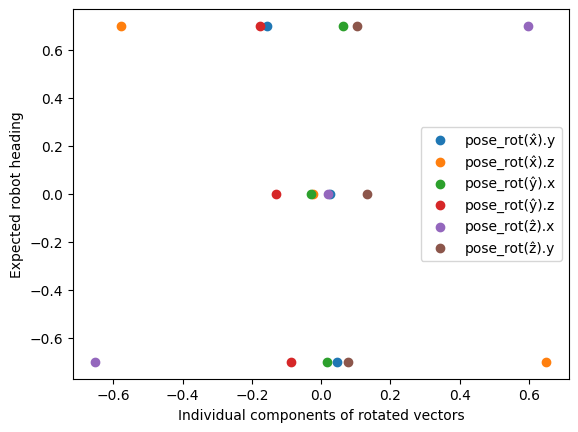

In [3]:
plt.scatter([q.apply([1,0,0])[1] for q in pose_rot], gt_hdg)
plt.scatter([q.apply([1,0,0])[2] for q in pose_rot], gt_hdg)
plt.scatter([q.apply([0,1,0])[0] for q in pose_rot], gt_hdg)
plt.scatter([q.apply([0,1,0])[2] for q in pose_rot], gt_hdg)
plt.scatter([q.apply([0,0,1])[0] for q in pose_rot], gt_hdg)
plt.scatter([q.apply([0,0,1])[1] for q in pose_rot], gt_hdg)
plt.legend([
    "pose_rot(x̂).y",
    "pose_rot(x̂).z",
    "pose_rot(ŷ).x",
    "pose_rot(ŷ).z",
    "pose_rot(ẑ).x",
    "pose_rot(ẑ).y",
])
plt.xlabel("Individual components of rotated vectors")
plt.ylabel("Expected robot heading")
# [q.apply([0,1,0]) for q in pose_rot]
# [x for x in zip([q.apply([0,0,1]) for q in pose_rot], gt_hdg)]

From this data, it seems that when the robot is turned, there is rotation about the x-z plane,
evidenced by the correlation of the `pos_rot.apply(x̂).z` and `pos_rot.apply(ẑ).x` with the
robot's rotation (with more data, we'd see a sine/cosine).

## Position

Now we are going to try to extract information on the camera's position.

Let's first apply `tag_rot`'s rotation to `tag_pos` as a guessed first
step to predicting the camera position. Let's plot some histograms of
the x, y, and z axis values for the transformed `tag_pos`s to see if it
matches our expected data, which we should graph similarly.

Text(0.5, 0, 'Position (each axis, rotated by pose_rot)')

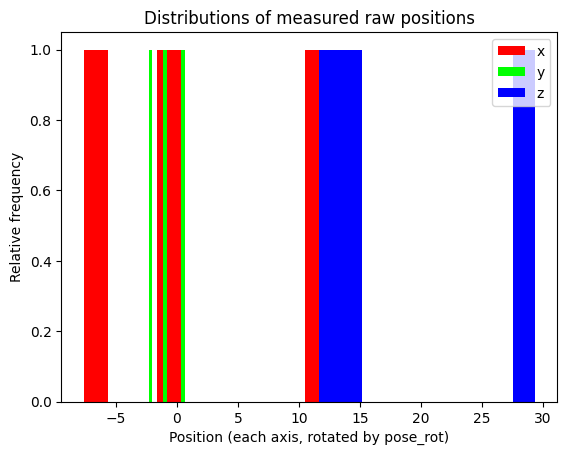

In [4]:
derotated = np.array([q.inv().apply(x) for (x,q) in zip(pose_pos, pose_rot)])
plt.hist(derotated[:,0],color="red")
plt.hist(derotated[:,1],color="lime")
plt.hist(derotated[:,2],color="blue")

plt.title("Distributions of measured raw positions")
plt.legend("xyz")
plt.ylabel("Relative frequency")
plt.xlabel("Position (each axis, rotated by pose_rot)")

Text(0.5, 0, 'Position (each axis)')

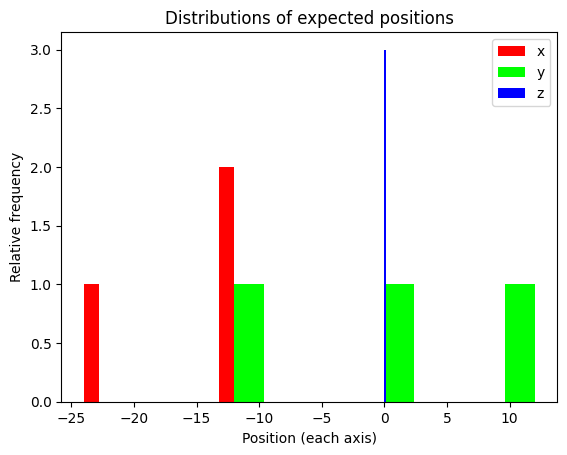

In [5]:
plt.hist(gt_pos[:,0],color="red")
plt.hist(gt_pos[:,1],color="lime")
plt.hist(gt_pos[:,2],color="blue")

plt.title("Distributions of expected positions")
plt.legend("xyz")
plt.ylabel("Relative frequency")
plt.xlabel("Position (each axis)")

There are a lot of similarities between these two plots.

I'll cut to the chase with how they're related:
- measured +x axis corresponds to expected +y axis
- measured +y axis corresponds to expected -z axis
- measured +z axis corresponds to expected -x axis

All that's left is to go back and write an algorithm to use this information to
predict the camera's position with this knowlege.

## Predictions

Now, here's the function that predicts the location of the camera using the
AprilTag pose information from above (eg. given (`pose_pos`, `pose_rot`),
predict (`gt_pos`, `gt_rot`)).

In [6]:
def predict_cam_loc(pose_pos: npt.ArrayLike, pos_rot: R) -> tuple[npt.ArrayLike, R]:
    derotated = pos_rot.inv().apply(pose_pos)
    predicted_pos = np.array([-derotated[2], derotated[0], -derotated[1]]) * 0.85

    # [x,_,z] = pos_rot.apply([1,0,0])
    # predicted_rot = math.atan2(z,x)
    [x,y,z,w] = pos_rot.as_quat()
    predicted_rot = R.from_quat([z,-x,y,w]) # same as pos coords lol but negative (inverse)

    return [predicted_pos,predicted_rot]

def predict_tag_loc(pose_pos: npt.ArrayLike, pos_rot: R) -> tuple[npt.ArrayLike, R]:
    [x,y,z] = pose_pos #pos_rot.inv().apply(pose_pos)
    predicted_pos = np.array([z, -x, y]) * 0.85

    # [x,_,z] = pos_rot.apply([1,0,0])
    # predicted_rot = math.atan2(z,x)
    [x,y,z,w] = pos_rot.inv().as_quat()
    predicted_rot = R.from_quat([z,-x,y,w]) # same as pos coords lol but negative (inverse)

    return [predicted_pos,predicted_rot]

Now we test, plotting each of the values of our predictions against the ground
truth expected positions. (We also plot an "Ideal" line representing a 1:1
correspondance).

[array([[-11.8575192 ,  -0.04076538,   0.89835603],
        [ -9.92948652,  -6.47996155,   1.95969373],
        [-24.93499328,  10.62039935,  -0.56615232]]),
 array([[ 0.01374039,  0.06611157,  0.01048216,  0.99766256],
        [-0.05780302,  0.07440801,  0.31050897,  0.94588923],
        [ 0.00765533,  0.04428935, -0.34753337,  0.93658977]])]

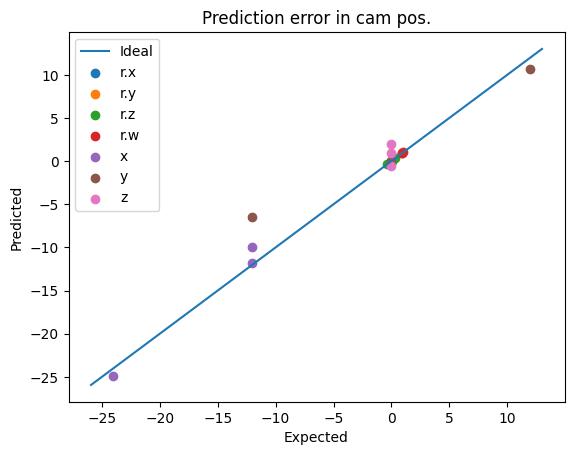

In [12]:
# [predicted_pos, predicted_hdg] = zip(*[predict_cam_loc(p, q) for (p, q) in zip(pose_pos, pose_rot)])
(predicted_pos, predicted_rot) = zip(*[predict_cam_loc(p, q) for (p, q) in zip(pose_pos, pose_rot)])
predicted_pos = np.array(predicted_pos)
predicted_rot = np.array([q.as_quat() for q in predicted_rot])

gt_rot_arr = np.array([q.as_quat() for q in gt_rot])

# all = np.concatenate([np.reshape(predicted_pos,(-1,)), np.reshape(predicted_hdg,(-1,)), np.reshape(gt_pos,(-1,)), np.reshape(gt_hdg,(-1,))])
all = np.concatenate([np.reshape(predicted_pos,(-1,)), np.reshape(predicted_rot,(-1,)), np.reshape(gt_pos,(-1,)), np.reshape(gt_rot_arr,(-1,))])
rang = [np.min(all)-1, np.max(all)+1]
plt.plot(rang, rang)
# plt.scatter(predicted_hdg, gt_hdg)
plt.scatter(predicted_rot[:,0], gt_rot_arr[:,0])
plt.scatter(predicted_rot[:,1], gt_rot_arr[:,1])
plt.scatter(predicted_rot[:,2], gt_rot_arr[:,2])
plt.scatter(predicted_rot[:,3], gt_rot_arr[:,3])
plt.scatter(gt_pos[:,0], predicted_pos[:,0])
plt.scatter(gt_pos[:,1], predicted_pos[:,1])
plt.scatter(gt_pos[:,2], predicted_pos[:,2])
plt.title("Prediction error in cam pos.")
plt.xlabel("Expected")
plt.ylabel("Predicted")
# plt.legend(["Ideal", "heading", "x", "y", "z"])
plt.legend(["Ideal", "r.x", "r.y", "r.z", "r.w", "x", "y", "z"])
# plt.legend(["r.x", "r.y", "r.z", "r.w"])
[predicted_pos, predicted_rot]

[array([[11.87043495, -0.21159494,  0.67636426],
        [12.00169754, -0.60727784,  0.12439242],
        [25.67051783,  8.18638692,  2.97907439]]),
 array([[ 0.01374039,  0.06611157,  0.01048216, -0.99766256],
        [-0.05780302,  0.07440801,  0.31050897, -0.94588923],
        [ 0.00765533,  0.04428935, -0.34753337, -0.93658977]])]

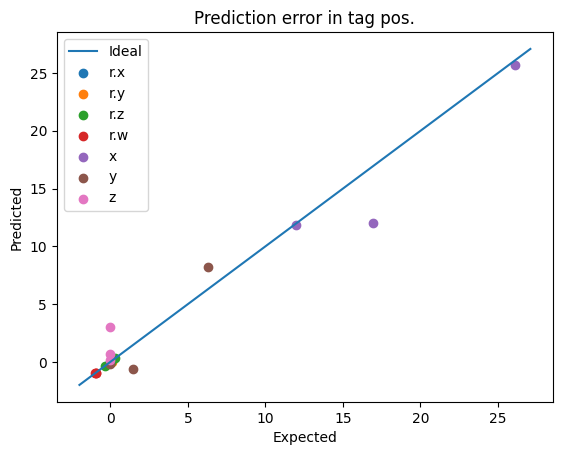

In [11]:
# [predicted_pos, predicted_hdg] = zip(*[predict_cam_loc(p, q) for (p, q) in zip(pose_pos, pose_rot)])
(predicted_pos, predicted_rot) = zip(*[predict_tag_loc(p, q) for (p, q) in zip(pose_pos, pose_rot)])
predicted_pos = np.array(predicted_pos)
predicted_rot = np.array([q.as_quat() for q in predicted_rot])

gt_rot_arr = np.array([q.as_quat() for q in gtfwd_rot])

# all = np.concatenate([np.reshape(predicted_pos,(-1,)), np.reshape(predicted_hdg,(-1,)), np.reshape(gt_pos,(-1,)), np.reshape(gt_hdg,(-1,))])
all = np.concatenate([np.reshape(predicted_pos,(-1,)), np.reshape(predicted_rot,(-1,)), np.reshape(gtfwd_pos,(-1,)), np.reshape(gt_rot_arr,(-1,))])
rang = [np.min(all)-1, np.max(all)+1]
plt.plot(rang, rang)
# plt.scatter(predicted_hdg, gt_hdg)
plt.scatter(predicted_rot[:,0], gt_rot_arr[:,0])
plt.scatter(predicted_rot[:,1], gt_rot_arr[:,1])
plt.scatter(predicted_rot[:,2], gt_rot_arr[:,2])
plt.scatter(predicted_rot[:,3], gt_rot_arr[:,3])
plt.scatter(gtfwd_pos[:,0], predicted_pos[:,0])
plt.scatter(gtfwd_pos[:,1], predicted_pos[:,1])
plt.scatter(gtfwd_pos[:,2], predicted_pos[:,2])
plt.title("Prediction error in tag pos.")
plt.xlabel("Expected")
plt.ylabel("Predicted")
# plt.legend(["Ideal", "heading", "x", "y", "z"])
plt.legend(["Ideal", "r.x", "r.y", "r.z", "r.w", "x", "y", "z"])
# plt.legend(["r.x", "r.y", "r.z", "r.w"])
# plt.legend(["x", "y", "z"])
[predicted_pos, predicted_rot]

That's pretty good :3c.

[array([[11.87043495, -0.21159494,  0.67636426],
        [12.00169754, -0.60727784,  0.12439242],
        [25.67051783,  8.18638692,  2.97907439]]),
 array([[ 0.01374039,  0.06611157,  0.01048216, -0.99766256],
        [-0.05780302,  0.07440801,  0.31050897, -0.94588923],
        [ 0.00765533,  0.04428935, -0.34753337, -0.93658977]])]